In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import scipy.optimize as optimize

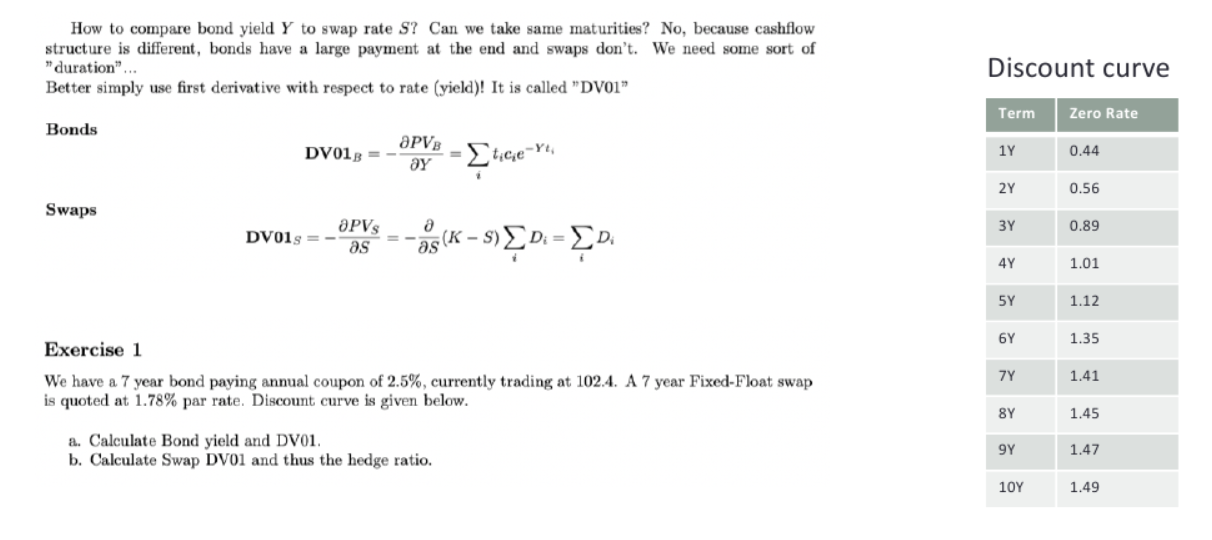

**Solution 1a**


In [2]:
def bond_ytm(price, par, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T
    coupon = coup /100. * par
    dt = [(i+1) / freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon / freq / np.exp(1)**(y / freq * t) for t in dt]) + par / np.exp(1)**(y / freq * T) - price
    return optimize.newton(ytm_func, guess)

Y = bond_ytm(price=102.4,par=100.0,T=7,coup=2.5,freq=1)
print("Bond yield: {:.2f}%".format(100*Y))

Bond yield: 2.11%


In [3]:
def bond_dv01(coupons,T,Y):
    return sum([(i+1)*coupons[i]*np.exp(-Y*(i+1)) for i in range(T)]) 

c_i = [2.5*0.01 for i in range(6)]
c_i.append(102.5*0.01)

dv01_b = bond_dv01(c_i,T=7,Y=Y)
print("Bond DV01: {:.2f}".format(dv01_b))


Bond DV01: 6.67


**Solution 1b**

$$DV01_S = \sum_{i} D_i = \sum_{i} e^{-Y_it_i}$$



In [4]:

def swap_dv01(T,discount_curve):
    return sum([np.exp(-discount_curve[i]*(i+1)) for i in range(T)])

discount_curve = np.array([0.44,0.56,0.89,1.01,1.12,1.35,1.41,1.45,1.47,1.49])/100
dv01_s = swap_dv01(7,discount_curve)

print("Swap DV01: {:.2f}".format(dv01_s))


Swap DV01: 6.69


Используем аддитивность DV01 и строим такое соотношение, чтобы DV01 совпали:
$$Bonds \cdot DV01_B = Swaps \cdot DV01_S$$
$$Hedge\ Ratio = Bonds/Swaps = DV01_S/DV01_B$$

Замечаем, что $DV01_S$ и $Hedge\ Ratio$ не зависят от par swap rate: $PV_S$ зависит от него линейно, значит, изменение $PV_S$ зависеть не должно

In [5]:
hedge_ratio = dv01_s/dv01_b
print("Hedge Ratio: {:.5f}".format(hedge_ratio))

Hedge Ratio: 1.00313


**Solution 2.1**

a. По условию, $S_t = S_0 + N(0,\sigma_S^2t)$ и $X_t = X_0 + N(0,\sigma_X^2t)$.

Тогда $A_t = A_0 + N(0,(\sigma_S^2+\sigma_X^2)t)$ или $dA_t = \sqrt{\sigma_S^2+\sigma_X^2}dV_t$ 

\
b. Найдём сначала $Var(A_t)$
$$ Var(A_t) = Var(S_t + X_t) = Var(S_t)+Var(X_t)+2Cov(X_t,S_t) = Var(\int_{0}^{t} \sigma_S \,dW_t) + Var(\int_{0}^{t} \sigma_X \,dZ_t)  = \sigma_S^2Var(W_t) + \sigma_X^2Var(Z_t) = \sigma_S^2t+\sigma_X^2t,$$ 
так как $X_t$ и $S_t$ не коррелируют. 


$$Cov(A_t,S_t) = Cov(S_t+X_t,S_t) = Cov(S_t,S_t) + Cov(X_t,S_t) = \sigma_S^2t$$
$$corr(A_t,S_t) = \frac{\sigma_S^2t}{\sqrt{\sigma_S^2t+\sigma_X^2t} \sqrt{\sigma_S^2t}} = \frac{\sigma_S}{\sqrt{\sigma_S^2 + \sigma_X^2}}$$



**Solution 2.2**

$$Call(S_t,K,\sigma,\tau) = \mathbb{E}_t[(S_T-K)]^+ = \mathbb{E}_t[S_T \mathbb{I}_{S_T > K}] - \mathbb{E}_t[K \mathbb{I}_{S_T > K}] = \mathbb{E}_t[S_T \mathbb{I}_{S_T > K}] - K \mathbb{Q}_t[S_T>K]$$

\
\
$$\mathbb{E}_t[S_T \mathbb{I}_{S_T > K}] = \frac{1}{\sqrt{2\pi\sigma^2\tau}} \int_{K}^{\infty} xe^{-\frac{(x-S_t)^2}{2\sigma^2\tau}} \,dx$$

Сделаем замену:
$$ y = \frac{x-S_t}{\sqrt{\sigma^2\tau}},\ x = y\sqrt{\sigma^2\tau}+S_t,\ dx = \sqrt{\sigma^2\tau}dy$$

Пусть $h = \frac{S_t-K}{\sqrt{\sigma^2\tau}}$, тогда 

$$\mathbb{E}_t[S_T \mathbb{I}_{S_T > K}] =  \frac{1}{\sqrt{2\pi\sigma^2\tau}} \int_{-h}^{\infty} (y\sqrt{\sigma^2\tau}+S_t) e^{-\frac{y^2}{2}} \sqrt{\sigma^2\tau} \,dy = \frac{\sqrt{\sigma^2\tau}}{\sqrt{2\pi}} \int_{-h}^{\infty} ye^{-\frac{y^2}{2}} \,dy + \frac{S_t}{\sqrt{2\pi}} \int_{-h}^{\infty} e^{-\frac{y^2}{2}} \,dy = \frac{\sqrt{\sigma^2\tau}}{\sqrt{2\pi}} \Big|_{-h}^{\infty} -e^{-\frac{y^2}{2}} + \frac{S_t}{\sqrt{2\pi}} \int_{-h}^{\infty} e^{-\frac{y^2}{2}} \,dy = \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} + \frac{S_t}{\sqrt{2\pi}} \int_{-h}^{\infty} e^{-\frac{y^2}{2}} \,dy$$

\
\
\
$$\mathbb{Q}_t[S_T>K] = \frac{1}{\sqrt{2\pi\sigma^2\tau}} \int_{K}^{\infty} e^{-\frac{(x-S_t)^2}{2\sigma^2\tau}} \,dx$$

Делаем аналогичную замену:
$$ \mathbb{Q}_t[S_T>K] = \frac{1}{\sqrt{2\pi\sigma^2\tau}} \int_{-h}^{\infty}  e^{-\frac{y^2}{2}} \sqrt{\sigma^2\tau} \,dy = \frac{1}{\sqrt{2\pi}} \int_{-h}^{\infty}  e^{-\frac{y^2}{2}} \,dy $$

\
\
\
Собираем всё вместе:
$$Call(S_t,K,\sigma,\tau) = \mathbb{E}_t[S_T \mathbb{I}_{S_T > K}] - K \mathbb{Q}_t[S_T>K] = \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} + \frac{S_t}{\sqrt{2\pi}} \int_{-h}^{\infty} e^{-\frac{y^2}{2}} \,dy - \frac{K}{\sqrt{2\pi}} \int_{-h}^{\infty}  e^{-\frac{y^2}{2}} \,dy = (S_t-K)\int_{-h}^{\infty}  e^{-\frac{y^2}{2}} \,dy + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} = (S_t-K)(1-N(-h)) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} = (S_t-K)N(h) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}},$$
где $N(h)$ значение функции стандартного нормального распределения в точке $h$

**Solution 2.3**

Put-Call parity: 
$$S_T - K = [(S_T-K)]^+ + [(K-S_T)]^+  $$

$$ \mathbb{E}_t[S_T - K] =  \mathbb{E}_t [(S_T-K)]^+ + \mathbb{E}_t[(K-S_T)]^+ $$

$$S_t-K =  Call(S_t,K,\sigma,\tau) - Put(S_t,K,\sigma,\tau)$$

$$Put(S_t,K,\sigma,\tau) = Call(S_t,K,\sigma,\tau) - S_t + K = (S_t-K)N(h) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} -S_t + K = (K-S_t)(1-N(h)) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}} = (K-S_t)N(-h) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{h^2}{2}}$$

**Solution 2.4**
$$\frac{\partial Call(S_t,K,\sigma,\tau)}{\partial S_t} = \left[ (S_t-K) N\left( \frac{S_t-K}{\sqrt{\sigma^2\tau}}\right) + \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{ \left( \frac{S_t-K}{\sqrt{\sigma^2\tau}} \right)^2}{2}} \right]'_{S_t} = N\left( \frac{S_t-K}{\sqrt{\sigma^2\tau}}\right) + (S_t-K) \frac{1}{\sqrt{2\pi}} e^{-\frac{ \left( \frac{S_t-K}{\sqrt{\sigma^2\tau}} \right)^2}{2}} \frac{1}{\sigma\sqrt{\tau}} - \frac{\sigma\sqrt{\tau}}{\sqrt{2\pi}} \left( \frac{S_t-K}{\sqrt{\sigma^2\tau}} \right) e^{-\frac{ \left( \frac{S_t-K}{\sqrt{\sigma^2\tau}} \right)^2}{2}} \frac{1}{\sigma\sqrt{\tau}} = N\left( \frac{S_t-K}{\sqrt{\sigma^2\tau}}\right) + \frac{S_t-K}{\sqrt{2\pi\sigma^2\tau}} e^{-\frac{(S_t-K)^2}{2\sigma^2\tau}} - \frac{S_t-K}{\sqrt{2\pi\sigma^2\tau}} e^{-\frac{(S_t-K)^2}{2\sigma^2\tau}} = N\left( \frac{S_t-K}{\sqrt{\sigma^2\tau}}\right) $$

\
\
Используя Put-Call Parity, получим, что:
\
\
$$\frac{\partial Put(S_t,K,\sigma,\tau)}{\partial S_t} = \frac{\partial Call(S_t,K,\sigma,\tau)}{\partial S_t} - 1 = N\left( \frac{S_t-K}{\sqrt{\sigma^2\tau}}\right) - 1 = -N\left( \frac{K-S_t}{\sqrt{\sigma^2\tau}}\right)$$ 

**Solution 2.5**
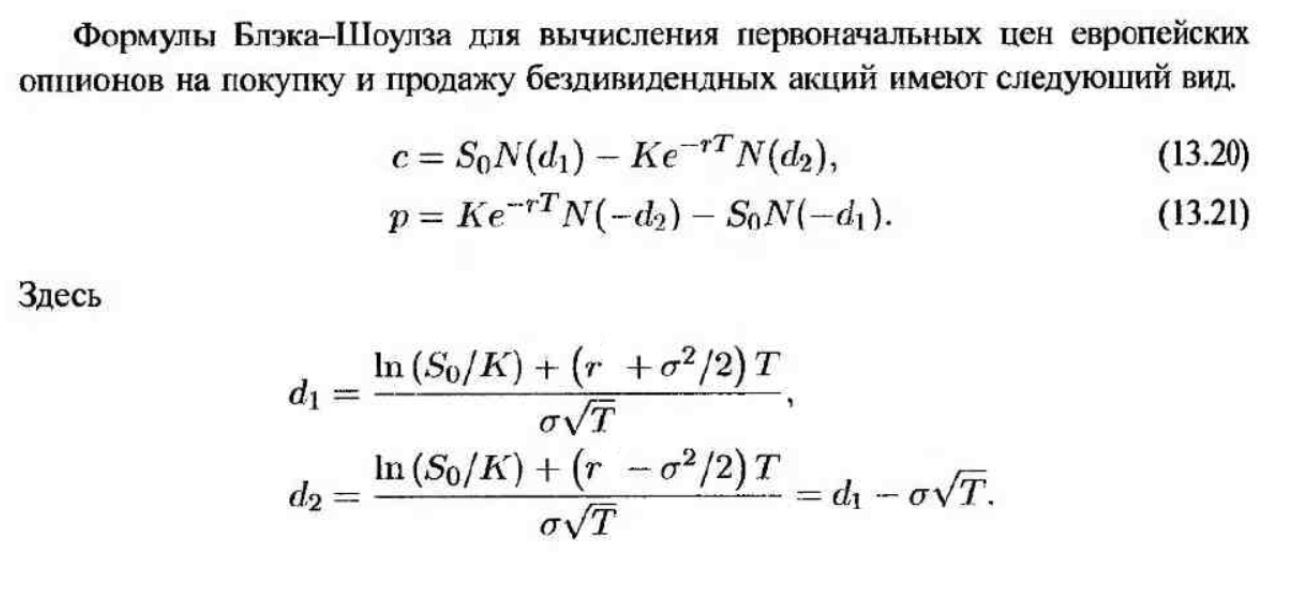

In [ ]:
def price_option_Bachelier(option_type,S,K,sigma,T):
  """
  Функция для оценки опциона по формуле Башелье

  Input
  -----
  option_type: str
      Тип опциона: put или call
  S: float
      Цена underlying актива
  K: float
      Страйк-цена
  sigma: float
      Волатильность
  T: float
      Время до исполнения
  Output
  ------
  option price: float
      Цена опциона
  
  """
    h = (S-K)/(sigma*np.sqrt(T))

    if option_type == 'call':
    return (S-K)*ss.norm.cdf(h) + sigma*np.sqrt(T)*np.exp(-1.0*h**2 / 2) / np.sqrt(2*np.pi)

    elif option_type == 'put':
    return (K-S)*ss.norm.cdf(-1.0*h) + sigma*np.sqrt(T)*np.exp(-1.0*h**2 / 2) / np.sqrt(2*np.pi)



def price_option_BSM(option_type,S,K,sigma,T):
  """
  Функция для оценки опциона по формуле Блэка-Шоулза-Мёртона

  Input
  -----
  option_type: str
      Тип опциона: put или call
  S: float
      Цена underlying актива
  K: float
      Страйк-цена
  sigma: float
      Волатильность
  T: float
      Время до исполнения
  Output
  ------
  option price: float
      Цена опциона
  
  """

    r = 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if option_type == 'call':
        return S*ss.norm.cdf(d1) - K*np.exp(-r*T)*ss.norm.cdf(d2)

    elif option_type == 'put':
        return K*np.exp(-r*T)*ss.norm.cdf(-1.0*d2) - S*ss.norm.cdf(-1.0*d1)

def price_options_and_draw(formula,variable,S,K,sigma,T):
  """
  Функция для оценки опциона при изменении одного параметра и рисования графиков

  Input
  -----
  formula: str
      Формула для оценки, BSM или Bachelier
  variable: str
      Изменяемый параметр: S, K, sigma или T
  S: float or iterable
      Цена underlying актива
  K: float or iterable
      Страйк-цена
  sigma: float or iterable
      Волатильность
  T: float or iterable
      Время до исполнения

  """
    if variable == 'S':
        prices_call = [price_option_BSM('call',x,K,sigma,T) for x in S] if formula == 'BSM' else [price_option_Bachelier('call',x,K,sigma*K,T) for x in S]
        prices_put = [price_option_BSM('put',x,K,sigma,T) for x in S] if formula == 'BSM' else [price_option_Bachelier('put',x,K,sigma*K,T) for x in S]
        x_axis = 'S (Underlying asset spot)'
        X = S
    elif variable == 'K':
        prices_call = [price_option_BSM('call',S,x,sigma,T) for x in K] if formula == 'BSM' else [price_option_Bachelier('call',S,x,sigma*K,T) for x in K]
        prices_put = [price_option_BSM('put',S,x,sigma,T) for x in K] if formula == 'BSM' else [price_option_Bachelier('put',S,x,sigma*K,T) for x in K]
        X = K
        x_axis = 'K (Strike)'
    elif variable == 'sigma':
        prices_call = [price_option_BSM('call',S,K,x,T) for x in sigma] if formula == 'BSM' else [price_option_Bachelier('call',S,K,x*K,T) for x in sigma]
        prices_put = [price_option_BSM('put',S,K,x,T) for x in sigma] if formula == 'BSM' else [price_option_Bachelier('put',S,K,x*K,T) for x in sigma]
        X = sigma
        x_axis = 'Sigma (Volatility)'
    elif variable == 'T':
        prices_call = [price_option_BSM('call',S,K,sigma,x) for x in T] if formula == 'BSM' else [price_option_Bachelier('call',S,K,sigma*K,T) for x in T]
        prices_put = [price_option_BSM('put',S,K,sigma,x) for x in T] if formula == 'BSM' else [price_option_Bachelier('put',S,K,sigma*K,T) for x in T]
        X = T
        x_axis = 'T (Time to exercise)'
    plt.figure(figsize=(10,5))
    plt.plot(X,prices_call)
    plt.plot(X,prices_put)
    plt.xlabel(x_axis)
    plt.title('Options price using '+formula + ' formula')
    plt.legend(['Call','Put'])
    plt.ylabel('Option price')
    plt.show()

    return prices_call,prices_put

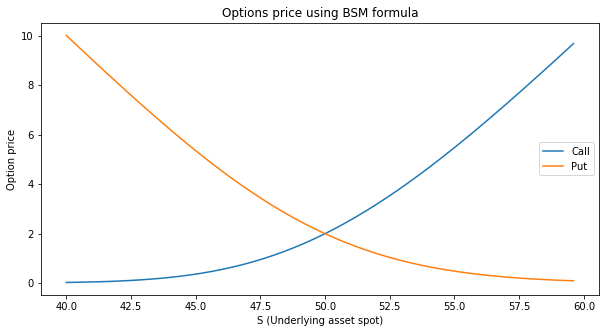

In [ ]:

prices_call_BSM,prices_put_BSM = price_options_and_draw('BSM','S',[40+x/2.5 for x in range(50)],K=50,sigma=0.1,T=1)

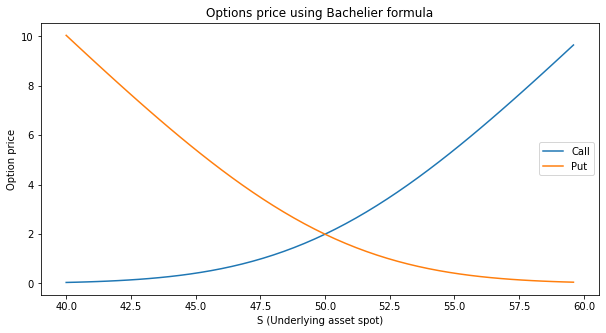

In [ ]:
prices_call_Bachelier, prices_put_Bachelier = price_options_and_draw('Bachelier','S',[40+x/2.5 for x in range(50)],K=50,sigma=0.1,T=1)

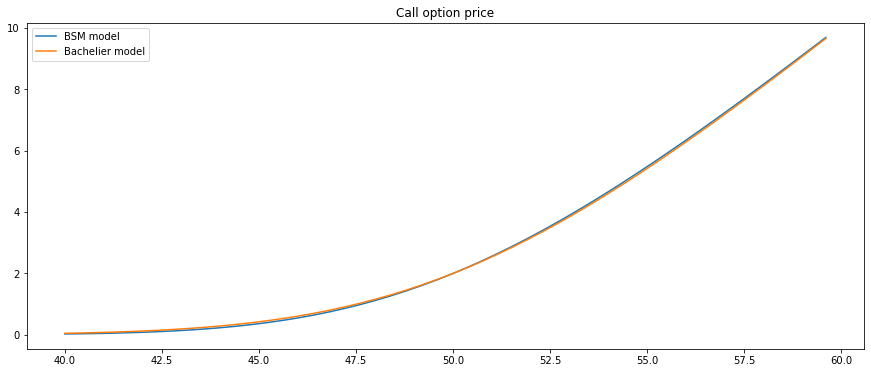

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([40+x/2.5 for x in range(50)],prices_call_BSM)
plt.plot([40+x/2.5 for x in range(50)],prices_call_Bachelier)
plt.legend(['BSM model','Bachelier model'])
plt.title('Call option price')
plt.show()

In [ ]:
def get_option_delta_BSM(option_type,S,K,sigma,T):
  """
  Функция для подсчёта дельты опциона по формуле Блэка-Шоулза-Мёртона

  Input
  -----
  option_type: str
      Тип опциона: put или call
  S: float
      Цена underlying актива
  K: float
      Страйк-цена
  sigma: float
      Волатильность
  T: float
      Время до исполнения
  Output
  ------
  delta: float
      Дельта опциона
  
  """
    r = 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if option_type == 'call':
        return ss.norm.cdf(d1)
    elif option_type == 'put':
        return ss.norm.cdf(d1)-1


def get_option_delta_Bachelier(option_type,S,K,sigma,T):
  """
  Функция для подсчёта дельты опциона по формуле Башелье

  Input
  -----
  option_type: str
      Тип опциона: put или call
  S: float
      Цена underlying актива
  K: float
      Страйк-цена
  sigma: float
      Волатильность
  T: float
      Время до исполнения
  Output
  ------
  delta: float
      Дельта опциона
  
  """

    h = (S-K)/(sigma*np.sqrt(T))

    if option_type == 'call':
        return ss.norm.cdf(h)
    elif option_type == 'put':
        return -1.0*ss.norm.cdf(-1.0*h)


def get_delta_and_draw(formula,variable,S,K,sigma,T):
  """
  Функция для подсчёта дельты опциона при изменении одного параметра и рисования графиков

  Input
  -----
  formula: str
      Формула для оценки, BSM или Bachelier
  variable: str
      Изменяемый параметр: S, K, sigma или T
  S: float or iterable
      Цена underlying актива
  K: float or iterable
      Страйк-цена
  sigma: float or iterable
      Волатильность
  T: float or iterable
      Время до исполнения

  """

    if variable == 'S':
        deltas_call = [get_option_delta_BSM('call',x,K,sigma,T) for x in S] if formula == 'BSM' else [get_option_delta_Bachelier('call',x,K,sigma*K,T) for x in S]
        deltas_put = [get_option_delta_BSM('put',x,K,sigma,T) for x in S] if formula == 'BSM' else [get_option_delta_Bachelier('put',x,K,sigma*K,T) for x in S]
        x_axis = 'S (Underlying asset spot)'
        X = S
    elif variable == 'K':
        deltas_call = [get_option_delta_BSM('call',S,x,sigma,T) for x in K] if formula == 'BSM' else [get_option_delta_Bachelier('call',S,x,sigma*K,T) for x in K]
        deltas_put = [get_option_delta_BSM('put',S,x,sigma,T) for x in K] if formula == 'BSM' else [get_option_delta_Bachelier('put',S,x,sigma*K,T) for x in K]
        X = K
        x_axis = 'K (Strike)'
    elif variable == 'sigma':
        deltas_call = [get_option_delta_BSM('call',S,K,x,T) for x in sigma] if formula == 'BSM' else [get_option_delta_Bachelier('call',S,K,x*K,T) for x in sigma]
        deltas_put = [get_option_delta_BSM('put',S,K,x,T) for x in sigma] if formula == 'BSM' else [get_option_delta_Bachelier('put',S,K,x*K,T) for x in sigma]
        X = sigma
        x_axis = 'Sigma (Volatility)'
    elif variable == 'T':
        deltas_call = [get_option_delta_BSM('call',S,K,sigma,x) for x in T] if formula == 'BSM' else [get_option_delta_Bachelier('call',S,K,sigma*K,x) for x in T]
        deltas_put = [get_option_delta_BSM('put',S,K,sigma,x) for x in T] if formula == 'BSM' else [get_option_delta_Bachelier('put',S,K,sigma*K,x) for x in T]
        X = T
        x_axis = 'T (Time to exercise)'
  
    plt.figure(figsize=(10,5))
    plt.plot(X,deltas_call)
    plt.plot(X,deltas_put)
    plt.legend(['Call','Put'])
    plt.title('Delta using '+formula + ' formula')
    plt.xlabel(x_axis)
    plt.ylabel('Option delta')
    plt.show()
    return deltas_call, deltas_put

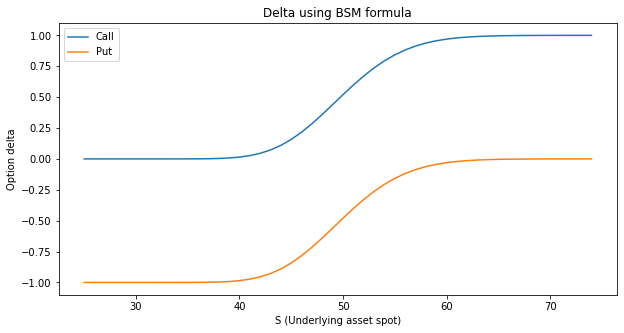

In [ ]:
deltas_call_BSM, deltas_put_BSM = get_delta_and_draw('BSM','S',[25+x for x in range(50)],K=50,sigma=0.1,T=1)

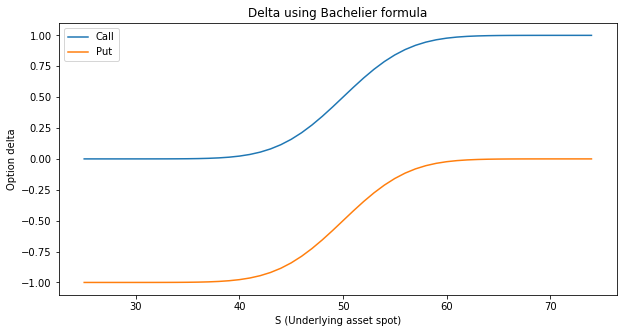

In [ ]:
deltas_call_Bachelier, deltas_put_Bachelier = get_delta_and_draw('Bachelier','S',[25+x for x in range(50)],K=50,sigma=0.1,T=1)

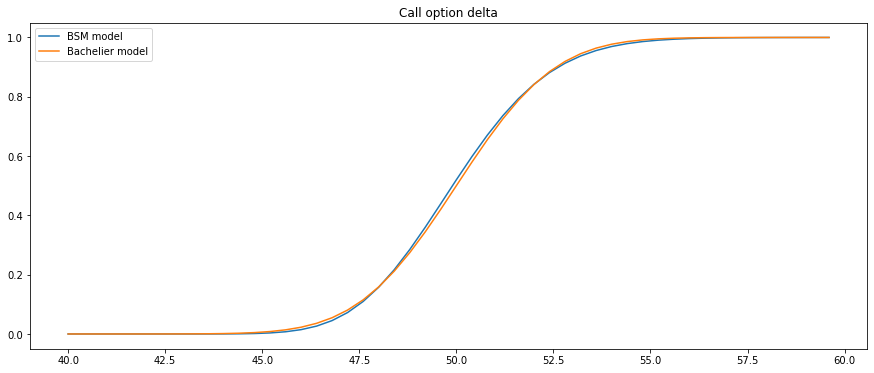

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([40+x/2.5 for x in range(50)],deltas_call_BSM)
plt.plot([40+x/2.5 for x in range(50)],deltas_call_Bachelier)
plt.legend(['BSM model','Bachelier model'])
plt.title('Call option delta')
plt.show()

**Solution 3**

In [ ]:
data_path = '/content/drive/MyDrive/CMF/project-spread/data.csv'
df = pd.read_csv(data_path)
df['Date'] = df['Date'].apply(lambda x: pd.Timestamp(x))
df['USSWAP2Y']  = 100*df['USSWAP2Y'] 
df['USGOVT2Y']  = 100*df['USGOVT2Y'] 
df['Spread'] = df['USSWAP2Y'] - df['USGOVT2Y']
df.head()

,Date,USSWAP2Y,USGOVT2Y,Spread
0,2017-01-02,145.50,119.03,26.47
1,2017-01-03,146.73,121.61,25.12
2,2017-01-04,146.13,121.60,24.53
3,2017-01-05,143.10,116.40,26.70
4,2017-01-06,148.43,121.18,27.25


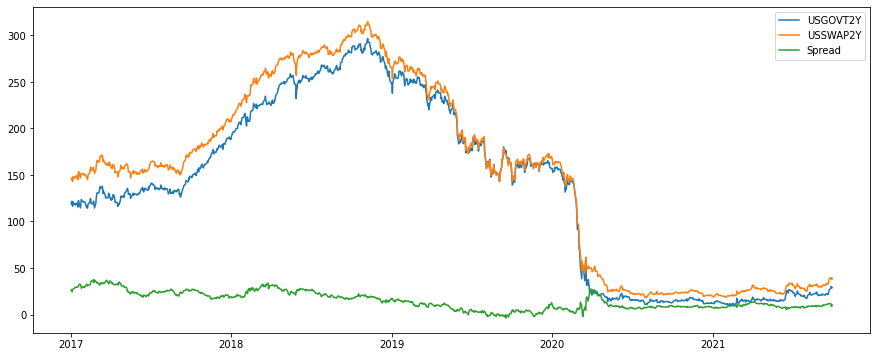

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df['Date'],df['USGOVT2Y'])
plt.plot(df['Date'],df['USSWAP2Y'])
plt.plot(df['Date'],df['Spread'])
plt.legend(['USGOVT2Y','USSWAP2Y','Spread'])
plt.show()

**Solution 3a**

In [ ]:
lag = 1
sigma_s = (df['USSWAP2Y'].diff(lag)).std() * np.sqrt(252/lag)
sigma_x = (df['Spread'].diff(lag)).std() * np.sqrt(252/lag)
print("Annual Swap Rate volatility = {}".format(sigma_s))
print("Annual Swap Spread volatility = {}".format(sigma_x))

Annual Swap Rate volatility = 45.44758318576925
Annual Swap Spread volatility = 16.98458467324265


Пусть $W_t$ - Винеровский процесс. Тогда
$$\frac{W_{t} - W_{s}}{\sqrt{t-s}}  \sim N(0,\sigma^2)$$

То есть, после нормировки на $\sqrt{t-s}$ дисперсия должна быть постоянна

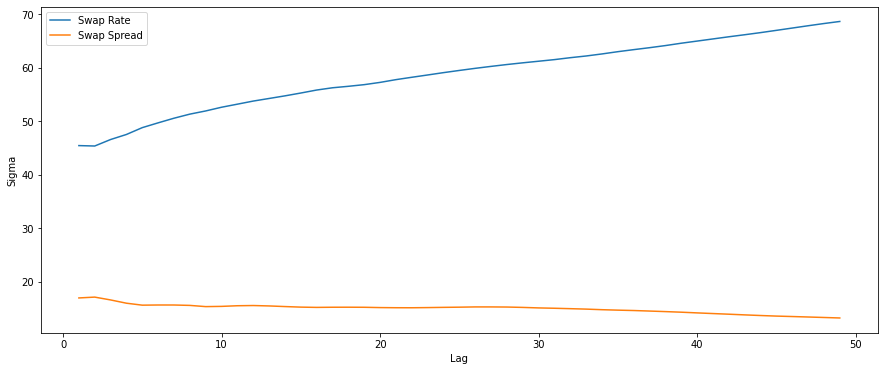

In [ ]:
lags = [x for x in range(1,50)]
sigmas_s = [(df['USSWAP2Y'].diff(lag)).std() * np.sqrt(252/lag) for lag in lags]
sigmas_x = [(df['Spread'].diff(lag)).std() * np.sqrt(252/lag) for lag in lags]

plt.figure(figsize=(15,6))
plt.plot(lags,sigmas_s)
plt.plot(lags,sigmas_x)
plt.legend(['Swap Rate','Swap Spread'])
plt.xlabel('Lag')
plt.ylabel('Sigma')
plt.show()

**Solution 3b**

Чтобы понять, является ли ряд $X_t$ Винеровским процессом, протестируем гипотезу, что его приращения нормальны. Более формально, для заданного временного окна от $s$ до $t$ $X_t - X_s$ должен быть нормально распределён с нулевым матожиданием и дисперсией, пропорциональной $t-s$.

In [ ]:
def perform_brownian_motion_tests(data,window_size,verbose=False):
  """
  Функция для проверки, что у данного ряда приращения нормально распределены

  Input
  -----
  data: pd.Series
      Значения ряда
  window_size: int
      Длина интервала, на котором смотрим приращения
  verbose: bool
      Флаг для печати

  """

    alpha = 0.05
    increments = data.diff(window_size).dropna()
    increments = (increments - increments.mean())/increments.std()
    n = len(increments)

  # используем 2-выборочный тест Колмогорова для проверки, что приращения распределены как нормальная выборка с нулевым матожиданием и дисперсией = 1
    desired_distribution = ss.norm.rvs(loc=0,scale=1,size=n)
    ks2test = ss.ks_2samp(increments,desired_distribution)
    if verbose:
        print("2 sample KS test:")
    if (ks2test[1] < alpha):
        print(" Reject H0, p-value = ",ks2test[1])
    else:
        print(' Do not reject H0, p-value = ',ks2test[1])
    print('------------------------------------')

  
  # проверяем, что скошенность как у нормального распределения (0)
    skewtest = ss.skewtest(increments)
    if verbose:
        print("Skewness test:")
    if (skewtest[1] < alpha):
        print(" Reject H0, p-value = ",skewtest[1])
    else:
        print(' Do not reject H0, p-value = ',skewtest[1])
    print('------------------------------------')

  # проверяем, что kurtosis как у нормального распределения
    kurtosistest = ss.kurtosistest(increments)
    if verbose:
        print("Kurtosis test:")
    if (kurtosistest[1] < alpha):
        print(" Reject H0, p-value = ",kurtosistest[1])
    else:
        print(' Do not reject H0, p-value = ',kurtosistest[1])
    print('------------------------------------')  
    print('====================================================================================================')


    return ks2test[1],skewtest[1],kurtosistest[1]



In [ ]:
res = perform_brownian_motion_tests(df['USSWAP2Y'],1,True)

2 sample KS test:
 Reject H0, p-value =  6.817634579895698e-09
------------------------------------
Skewness test:
 Reject H0, p-value =  1.0410005316629338e-40
------------------------------------
Kurtosis test:
 Reject H0, p-value =  2.6708338741406445e-40
------------------------------------


In [ ]:
# проведём тесты для swap rate и swap spread для разных значений окна, на котором рассматриваем приращения
swap_results = []
for i in [1,5,20]:
    res = perform_brownian_motion_tests(df['USSWAP2Y'],i,False)
    swap_results.append((i,)+res)

spread_results = []
for i in [1,5,20]:
    res = perform_brownian_motion_tests(df['Spread'],i,False)
    spread_results.append((i,)+res)

swap_tests = pd.DataFrame(swap_results,columns=['Lag','KS p-value','Skewness p-value','Kurtosis p-value'])
spread_tests = pd.DataFrame(spread_results,columns=['Lag','KS p-value','Skewness p-value','Kurtosis p-value'])

In [ ]:
spread_tests

,Lag,KS p-value,Skewness p-value,Kurtosis p-value
0,1,1.149669e-05,1.208520e-33,7.706233e-60
1,5,9.053333e-06,6.145638e-37,8.411029e-46
2,20,4.831410e-07,3.207915e-40,1.889057e-37


In [ ]:
swap_tests

,Lag,KS p-value,Skewness p-value,Kurtosis p-value
0,1,8.766431e-09,1.041001e-40,2.670834e-40
1,5,2.971949e-09,4.059047e-75,1.429501e-50
2,20,1.257784e-14,1.710909e-97,1.322477e-49


**Solution 3c**

In [ ]:
def perform_correlation_test(data1,data2,window_size):
  """
  Функция для тестирования гипотезы о значимой корреляции между рядами приращений
  data1: pd.Series
      Первый ряд
  data2: pd.Series
      Другой ряд
  window_size: int
      Интервал, на котором смотрим приращение

  """

    alpha = 0.05
    inc1 = data1.diff(window_size).dropna()
    inc2 = data2.diff(window_size).dropna()
    corr_test = ss.pearsonr(inc1,inc2)


    return (corr_test[0],corr_test[1])

In [ ]:
corr_results = []
for i in range(1,100):
    res = perform_correlation_test(df['Spread'],df['USSWAP2Y'],i)
    corr_results.append((i,)+res)

corr_tests = pd.DataFrame(corr_results,columns=['Lag','Correlation','p-value'])

In [ ]:
corr_tests

,Lag,Correlation,p-value
0,1,0.082897,0.003554
1,2,0.084021,0.003139
2,3,0.101375,0.000364
3,4,0.111768,0.000084
4,5,0.105937,0.000196
...,...,...,...
94,95,0.034277,0.247305
95,96,0.034815,0.240166
96,97,0.035165,0.235676
97,98,0.035612,0.229985


In [ ]:
print("Maximum absolute correlation:",abs(corr_tests['Correlation']).max())

Maximum absolute correlation: 0.11176836375113874
